## ICP-CDN Interaction Preprocessing

**Input:** Raw data table (hidden for future research purposes)

**Output:** Interactions matrix of dimension: num_users x num_items
* Go through raw data, keep track of which ICPs have used which CDNs
* Nonzero entries represent a recorded interaction
* Maintain *ICP-userindex* and *CDN-itemindex* mappings to remember which rows/columns correspond to which ICPs/CDNs

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import csv

In [2]:
# Read in ICP-CDN interactions (icpdomaincdntotalamountofmedia)
interactions_filepath = 'icpdomaincdntotalamountofmedia/all_interactions.txt'
interactions_header = ['industry','icp','domain','cdn',
                                      'totalsize','cdnsize','nocdnsize',
                                      'ts']
interactions_dtypes = {
    'industry': str,
    'icp': str,
    'domain': str,
    'cdn': str,
    'totalsize': np.float64,
    'cdnsize': np.float64,
    'nocdnsize': np.float64,
    'ts': str
}
interactions_df = pd.read_csv(interactions_filepath, 
                              sep=',', header=None, 
                              names=interactions_header,
                              dtype=interactions_dtypes)

In [3]:
interactions_df.head(15)

,industry,icp,domain,cdn,totalsize,cdnsize,nocdnsize,ts
0,0100,365jia.cn,365jia.cn,NaN,3.525360e+09,0.000000e+00,3.525360e+09,201501
1,0100,365jilin.com,365jilin.com,NaN,3.595730e+05,0.000000e+00,3.595730e+05,201501
2,0100,wfcmw.cn,wfcmw.cn,NaN,1.362390e+09,0.000000e+00,1.362390e+09,201501
3,0100,www.100ec.cn,www.100ec.cn,NaN,2.940954e+08,0.000000e+00,2.940954e+08,201501
4,0100,www.163.com,www.163.com,002,8.273679e+08,8.273679e+08,0.000000e+00,201501
5,0100,www.163.com,www.163.com,004,3.701383e+08,3.701383e+08,0.000000e+00,201501
6,0100,www.21cbh.com,www.21cbh.com,002,2.036111e+10,2.036111e+10,0.000000e+00,201501
7,0100,www.21cn.com,www.21cn.com,NaN,1.151693e+08,0.000000e+00,1.151693e+08,201501
8,0100,www.21cn.com,www.21cn.com,003,8.983205e+09,8.983205e+09,0.000000e+00,201501
9,0100,www.2500sz.com,www.2500sz.com,001,1.621454e+10,1.621454e+10,0.000000e+00,201501


In [4]:
interactions_df.duplicated().unique()

array([False], dtype=bool)

Looks good, no duplicate data

In [5]:
# # Read in ICP Statistics
# icp_statistics_filepath = 'icpstatistic/all_icp_statistics.txt'
# icp_statistics_header = ['icp', 'textnum', 'imagenum', 'videonum', 'unknownnum',\
#                         'textbytes','imagebytes','unknownbytes','createtime', 'ts']
# icp_statistics_dtypes = {
#     'icp': str,
#     'textnum': np.int64,
#     'imagenum': np.int64,
#     'videonum': np.int64,
#     'unknownnum': np.int64,
#     'textbytes': np.float64,
#     'imagebytes': np.float64,
#     'unknownbytes': np.float64,
#     'createtime': str,
#     'ts': str
# }
# icp_statistics_df = pd.read_csv(icp_statistics_filepath,
#                                sep=',', header=None,
#                                names=icp_statistics_header,
#                                dtype=icp_statistics_dtypes)

In [6]:
# icp_statistics_df.head()
# # Column numbers don't match! Look into this later

In [7]:
# Create lists of unique users (ICPs), items (CDNs)
icp_list = interactions_df.icp.unique()
cdn_list = interactions_df.cdn.unique()[1:] # remove NaN
n_users = icp_list.shape[0]
n_items = cdn_list.shape[0]

print "Num users (ICPs): " + str(n_users) + " | Num items (CDNs): " + str(n_items)
print icp_list
print cdn_list

Num users (ICPs): 1753 | Num items (CDNs): 39
['365jia.cn' '365jilin.com' 'wfcmw.cn' ..., 'www.metroer.com'
 'www.xy280.com' 'www.yccar.com']
['002' '004' '003' '001' '203' '013' '202' '005' '204' '201' '009' '007'
 '006' '008' '101' '104' '111' '102' '105' '014' '103' '106' '113' '110'
 '121' '116' '109' '125' '114' '108' '124' '107' '011' '119' '112' '117'
 '115' '122' '123']


In [8]:
# Check for duplicates with or without "www.__url__"
no_www_list = [url for url in icp_list if "www." not in url]
print no_www_list

['365jia.cn', '365jilin.com', 'wfcmw.cn', '1000eb.com', 'duoshuo.com', 'gai001.com', 'nut.com.cn', 'panasonic.cn', 'segmentfault.com', 't.cn', 'w.cn', 'wallstreetcn.com', '5173tuan.com', 'tuanweihui.com', 'new.sdo.com', 'lengxiaohua.cn', 'kdweibo.com', 'youyuan.com', '5lux.com', 'bab.la', 'shuaijiao.com', 'tsinghua.edu.cn']


In [9]:
for element in no_www_list:
    with_www = "www." + element
    print np.where(icp_list == with_www)

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


Confirmed: no "www" duplicates - yay

In [10]:
# Create interactions matrix + user-row, item-col mappings
interactions = np.zeros((n_users, n_items))

# user-row
uidx_to_icp = {} # User index to ICP
icp_to_uidx = {} # ICP to user index
for (index, icp) in enumerate(icp_list):
    uidx_to_icp[index] = icp
    icp_to_uidx[icp] = index
    
# item-col
iidx_to_cdn = {} # Item index to CDN
cdn_to_iidx = {} # CDN to item index
for (index, cdn) in enumerate(cdn_list):
    iidx_to_cdn[index] = cdn
    cdn_to_iidx[cdn] = index

# Read in entries
for entry in interactions_df.itertuples():
    icp = entry[2] # 2nd element
    cdn = entry[4] # 4th element
    if cdn > 0: # Remove NaN
        row = icp_to_uidx[icp]
        col = cdn_to_iidx[cdn]
        interactions[row, col] = 1

In [11]:
# Convert to compressed sparse-row matrix, check shape, num. interactions
interactions = sp.csr_matrix(interactions)
print "Matrix shape: " + str(interactions.shape)
print "Interaction pairs: " + str(interactions.getnnz())
# 2242 interaction pairs

Matrix shape: (1753, 39)
Interaction pairs: 2242


In [12]:
# Check number of ICPs that have used CDNs (non-empty rows)
interactions[interactions.getnnz(1) > 0].shape

(1151, 39)

In [13]:
# Check sparsity of remaining ICP-CDN matrix (if we remove empty rows)
sparsity = (1151*39 - 2242.)/(1151*39.)
print sparsity

0.950054579073


In [14]:
# Remove ICPs that haven't used CDNs from interactions matrix
rows_interacted = interactions.getnnz(1).astype(bool) # Boolean list of if row (ICP) has used a CDN
icp_list_remaining = icp_list[rows_interacted] # Remaining list of ICPs that have used CDNs
interactions_remaining = interactions[rows_interacted] # Remaining array, only includes ICPs that have used CDNs
num_users_remaining = interactions_remaining.shape[0]

assert (False not in interactions_remaining.getnnz(1)) # No empty rows remaining

In [15]:
# Redo user-row mappings using remaining ICP list
uidx_to_icp_remaining = {}
icp_to_uidx_remaining = {}
for (index, icp) in enumerate(icp_list_remaining):
    uidx_to_icp_remaining[index] = icp
    icp_to_uidx_remaining[icp] = index

In [16]:
# True if ICP has used a CDN (included in final matrix)
# False if ICP has NOT used a CDN (excluded from final matrix)
def has_used_cdn(icp_name):
    return icp_name in icp_to_uidx_remaining

In [17]:
# Use for testing: sort .csv by ICP name, plug in some names, see if result is correct
has_used_cdn('www.nipic.com')

True

In [18]:
# Just out of curiosity: See how many different CDNs each ICP has used (num. different interactions)
max_num_cdns = max(interactions_remaining.getnnz(1))
CDN_counts = np.zeros(max_num_cdns+1).astype(np.int32)

for num in range(0, max_num_cdns+1):
    CDN_counts[num] = interactions_remaining[interactions_remaining.getnnz(1) == num].shape[0]

for num_cdns, count in enumerate(CDN_counts):
    print "Number of CDNs: " + str(num_cdns) + " | " + "Count: " + str(count)

Number of CDNs: 0 | Count: 0
Number of CDNs: 1 | Count: 567
Number of CDNs: 2 | Count: 314
Number of CDNs: 3 | Count: 163
Number of CDNs: 4 | Count: 58
Number of CDNs: 5 | Count: 26
Number of CDNs: 6 | Count: 9
Number of CDNs: 7 | Count: 6
Number of CDNs: 8 | Count: 1
Number of CDNs: 9 | Count: 0
Number of CDNs: 10 | Count: 1
Number of CDNs: 11 | Count: 1
Number of CDNs: 12 | Count: 2
Number of CDNs: 13 | Count: 2
Number of CDNs: 14 | Count: 0
Number of CDNs: 15 | Count: 0
Number of CDNs: 16 | Count: 0
Number of CDNs: 17 | Count: 0
Number of CDNs: 18 | Count: 0
Number of CDNs: 19 | Count: 0
Number of CDNs: 20 | Count: 0
Number of CDNs: 21 | Count: 1


In [19]:
# How did 1 ICP use 21 different CDN providers?? Let's find out who it was
row = np.argmax(interactions_remaining.getnnz(1))
uidx_to_icp_remaining[row]

'www.gov.cn'

Of course it was the government

In [20]:
# Let's try training a simple implicit feedback CF model on all our interaction data
from lightfm import LightFM
import lightfm.evaluation

/Users/lucashu/anaconda/envs/recsys/lib/python2.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [21]:
# Code from Ethan Rosenthal's LightFM for Sketchfab tutorial
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)
        
def patk_learning_curve(model, train,
                       iterarray, user_features=None,
                       item_features=None, k=5,
                       **fit_params):
    old_epoch = 0
    train_patk = []
    headers = ['Epoch', 'train p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train,
                          user_features=user_features,
                          item_features=item_features,
                         epochs=more, **fit_params)
        this_train = lightfm.evaluation.precision_at_k(model, train, train_interactions=None, k=k)
        
        train_patk.append(np.mean(this_train))
        row = [epoch, train_patk[-1]]
        print_log(row)
    return model, train_patk

In [22]:
model = LightFM(loss='warp', random_state=2016)
model.fit(interactions_remaining, epochs=0) # just initialize

iterarray = range(10, 110, 10)
model, train_patk = patk_learning_curve(
    model, interactions_remaining, iterarray, k=5,
    **{'num_threads':1}
)

+------------+------------+
|   Epoch    | train p@5  |
+============+============+
|     10     |  0.34926   |
+------------+------------+
|     20     |  0.36507   |
+------------+------------+
|     30     |  0.37150   |
+------------+------------+
|     40     |  0.37480   |
+------------+------------+
|     50     |  0.37533   |
+------------+------------+
|     60     |  0.37550   |
+------------+------------+
|     70     |  0.37550   |
+------------+------------+
|     80     |  0.37550   |
+------------+------------+
|     90     |  0.37550   |
+------------+------------+
|    100     |  0.37550   |
+------------+------------+


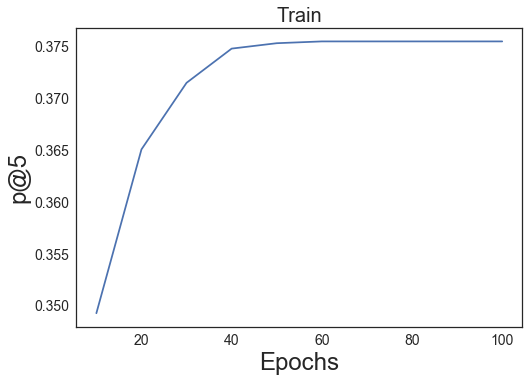

In [23]:
# Generate plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);
    
# Plot train on left
plot_patk(iterarray, train_patk,
         'Train', k=5)

plt.show();

Not bad! Still need to try with separate test data though.

TODO 6/28/17:
Create train-test splits
Implement user, item features

In [28]:
# Initial save: interactions matrix, index mappings
import pickle
with open('20170629-interactions-mappings.pkl', 'wb') as output:
    pickle.dump((interactions_remaining, \
                 iidx_to_cdn, cdn_to_iidx, \
                 uidx_to_icp_remaining, icp_to_uidx_remaining), \
                 output, -1)